In [19]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import os
import transformers
from accelerate import Accelerator

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
accelerator = Accelerator()
device = accelerator.device

In [20]:
from transformers import ViTImageProcessor, ViTForImageClassification, ViTConfig
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

pretrained_name = 'google/vit-base-patch16-224'
config = ViTConfig.from_pretrained(pretrained_name)
processor = ViTImageProcessor.from_pretrained(pretrained_name)
pred_model = ViTForImageClassification.from_pretrained(pretrained_name)
pred_model.to(device)

inputs = processor(images=image, return_tensors="pt")
inputs.to(device)
outputs = pred_model(**inputs, output_hidden_states=True)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", pred_model.config.id2label[predicted_class_idx])

Predicted class: Egyptian cat


In [21]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks=5, bottleneck_dim=64):
        super(MLP, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.layers = nn.ModuleList()
        for _ in range(num_blocks):
            shortcut_layers = []
            shortcut_layers.append(nn.Linear(hidden_dim, bottleneck_dim))
            shortcut_layers.append(nn.Dropout())
            shortcut_layers.append(nn.ReLU())  # Using ReLU for simplicity; you can choose other activations as needed
            shortcut_layers.append(nn.Linear(bottleneck_dim, bottleneck_dim))
            shortcut_layers.append(nn.Dropout())
            shortcut_layers.append(nn.Linear(bottleneck_dim, hidden_dim))
            # shortcut_layers.append(nn.BatchNorm1d(num_features=hidden_dim))
            shortcut_layers.append(nn.Dropout())
            self.layers.append(nn.Sequential(*shortcut_layers))

        self.output_layer= nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.input_layer(x)
        for layer in self.layers:
            residual = layer(x)
            x = x + residual # shortcut
        return self.output_layer(x)


def pairwise_cosine_similarity(Q, K):
    """
    Q: (N, d)
    K: (N, L, d)
    """
    attention_scores = torch.matmul(Q.unsqueeze(1), K.transpose(-2, -1)).squeeze(1) # [N, L]
    # denominator = torch.sqrt((Q**2).sum(-1).unsqueeze(-1) * (K**2).sum(-1).unsqueeze(-2))
    denominator = (K**2).sum(-1) # [N, L]
    attention_weights = attention_scores / (denominator + 1e-5)
    return attention_weights # [N, L]

# def pinv_float32(A):
#     """
#     Compute the Moore-Penrose pseudoinverse of a matrix using SVD,
#     ensuring all operations are performed in float32 precision.
    
#     Parameters:
#     - A: The input tensor of shape [..., M, N]
    
#     Returns:
#     - The pseudoinverse of A with float32 precision.
#     """
#     # Ensure A is float32
#     A = A.to(dtype=torch.float32)
    
#     # Compute SVD
#     U, S, Vh = torch.linalg.svd(A, full_matrices=False)
    
#     # Invert S with thresholding (regularization)
#     S_inv = torch.where(S > 1e-15, 1.0 / S, torch.tensor(0.0, device=S.device, dtype=S.dtype))
    
#     # Compute pseudoinverse
#     A_pinv = torch.matmul(Vh.transpose(-2, -1), torch.matmul(torch.diag_embed(S_inv), U.transpose(-2, -1)))
    
#     return A_pinv


class SimplifiedAttention(nn.Module):
    def __init__(self, embed_size):
        super(SimplifiedAttention, self).__init__()
        self.query = nn.Linear(embed_size, embed_size)
        self.key = nn.Linear(embed_size, embed_size)
        # self.value = nn.Linear(embed_size, embed_size)
    
    def forward(self, q, k, v):
        """
        q: (N, d)
        k: (N, L, d)
        v: (N, L, d)
        """
        Q = q # self.query(q) # [N, d]
        K = k # self.key(k) # [N, L, d]
        V = v # [N, L, d]
        Q_gate = self.query(q) # [N, d]
        K_gate = self.key(k) # [N, L, d]

        gate = torch.matmul(K_gate, Q_gate.unsqueeze(-1)).squeeze(-1) # [N, L]
        gate = torch.sigmoid(gate) # [N, L]

        
        # Compute the attention scores [N, L]
        # attention_scores = torch.matmul(Q.unsqueeze(1), K.transpose(-2, -1)).squeeze(1) / torch.sqrt(torch.tensor(Q.size(-1), dtype=torch.float32))
        attention_weights = pairwise_cosine_similarity(Q, K) # [N, L]
        # attention_weights = torch.softmax(attention_scores, dim=-1)
        
        # Compute the weighted sum of values using the attention weights
        attention_outputs = attention_weights.unsqueeze(-1) * V # (N, L, d)
        # pseudo_inverse_K = pinv_float32(K.transpose(-2, -1)) # get pseudoinverse K(K^T K)^{-1} # [N, L, d]

        # zoomed_projection = torch.matmul(K, q.unsqueeze(-1)).squeeze(-1) # get a direct projection, which is not rescaled # [N, L]

        # projection = torch.matmal(pseudo_inverse_K.transpose(-2, -1), zoomed_projection.unsqueeze(-1)).squeeze(-1) # [N, d]
        # projection = pseudo_inverse_K * zoomed_projection.unsqueeze(-1) # [N, L, d]

        return attention_outputs, gate  # Return  [N, L, d], [N, L]

        # return projection, gate  # Return  [N, L, d], [N, L]


def normalize(x, device):
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).reshape(1,-1,1,1)
    std = torch.tensor([0.229, 0.224, 0.225], device=device).reshape(1,-1,1,1)
    return (x - mean) / std


def convert_mask_patch(pixel_values, mask, h_patch, w_patch):
    reshaped_mask = mask.reshape(-1, h_patch, w_patch).unsqueeze(1) # [N, 1, h_patch ,w_patch]
    image_size = pixel_values.shape[-2:]
    reshaped_mask = torch.nn.functional.interpolate(reshaped_mask, size=image_size, mode='nearest')
    return pixel_values * reshaped_mask


def idx_to_selector(idx_tensor, selection_size):
    """
    Convert a labels indices tensor of shape [batch_size] 
    to one-hot encoded tensor [batch_size, selection_size]

    """
    batch_size = idx_tensor.shape[0]
    dummy = torch.arange(selection_size, device=idx_tensor.device).unsqueeze(0).expand(batch_size, -1)
    extended_idx_tensor = idx_tensor.unsqueeze(-1).expand(-1, selection_size)
    return (dummy == extended_idx_tensor).float()


class SurrogateInterpretation(nn.Module):
    def __init__(self, query_vector_size) -> None:
        """
        pred_model: prediction model
        classifier_head: last fully connected layer 
        """
        super().__init__()

        # self.feature_extractor = feature_extractor
        patch_size = 16
        n_patches = (224 * 224) // (patch_size * patch_size)
        self.n_patches = n_patches

        self.h_patch = 224 // patch_size
        self.patch_embedding = nn.Conv2d(3, query_vector_size, kernel_size=patch_size, stride=patch_size)


        # Transform function to non-linearly transform feature map embedding to the representation space
        self.transform_func = MLP(input_dim=query_vector_size,
                                  hidden_dim=query_vector_size,
                                  output_dim=n_patches,
                                  num_blocks=5,
                                  bottleneck_dim=64)
        # self.attention = SimplifiedAttention(embed_size=query_vector_size)
        # self.classifer = nn.Linear(query_vector_size, num_labels, bias=False)
        
        self.cls_loss_func = nn.CrossEntropyLoss()
        # self.sim_loss_func = nn.MSELoss()
        # # self.cls_loss_func = nn.NLLLoss()
        # self.kl_loss = torch.nn.KLDivLoss(reduction='batchmean', log_target=True)
        # self.cossim_loss_func = nn.CosineSimilarity(dim=-1)
    
    
    def compute_loss(self, pred, pseudo_label, gate):    
        """
        pred: [N, 1000]
        pseudo_label: [N,]
        gate: [N, L]
        """
        true_selector = idx_to_selector(pseudo_label, selection_size=pred.shape[-1]) # [N, 1000]
        prob = torch.softmax(pred, dim=-1) # [N, 1000]
        true_prob = (prob * true_selector).sum(-1) # [N,] probability
        pred_label = pred.argmax(dim=-1).view(-1) # [N,]

        batch_acc = (pred_label == pseudo_label).float().

        mask = (pred_label == pseudo_label).float() # [N,] mask

        cls_loss = self.cls_loss_func(pred, pseudo_label)
        # (1 - mask) is the ones with incorrect prediction
        # if the the prediction is correct, then mask the input furhter by gate
        masked_gate = gate * mask.unsqueeze(-1) # (N, L)
        gate_loss = masked_gate.sum() / (mask.sum())

        loss = cls_loss + 0.01 * gate_loss

        return {'loss':loss, 
                'cls_loss': cls_loss,
                'gate_loss': gate_loss
                }
        
    
    def forward(self, pixel_values, query_vector):
        """ 
        pixel_values: [N, 3, 224, 224]
        query_vector: [N, d]
        pseudo_probs: [N, 1000]
        label: [N,]
        """     
        h_patch = self.h_patch
        
        gate_logits = self.transform_func(query_vector) # [N, d] ->  [N, L] convert to L patch prediction
        gate = torch.sigmoid(gate_logits) # [N, L] convert to values between [0, 1]
        gated_pixel_values = convert_mask_patch(pixel_values=pixel_values, mask=gate, h_patch=h_patch, w_patch=h_patch) # N, 

        return {"gated_pixel_values" :gated_pixel_values,
                "query_vector": query_vector,
                "gate": gate,
        }

In [22]:
from torchvision.transforms import (CenterCrop, Compose, Normalize, RandomHorizontalFlip, RandomResizedCrop, Resize, ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
    [
        RandomResizedCrop(size),
        RandomHorizontalFlip(),
        ToTensor(),
        Normalize(mean=image_mean, std=image_std)
    ]
)

_val_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        Normalize(mean=image_mean, std=image_std)
    ]
)

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert('RGB')) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert('RGB')) for image in examples['image']]
    return examples

from datasets import load_dataset
dataset = load_dataset("mrm8488/ImageNet1K-val")
dataset = dataset['train']
splits = dataset.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)

from torch.utils.data import DataLoader

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Repo card metadata block was not found. Setting CardData to empty.


In [23]:
batch_size = 256
train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_ds, collate_fn=collate_fn, batch_size=1024, shuffle=True)

batch = next(iter(train_dataloader))
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)

pixel_values torch.Size([256, 3, 224, 224])
labels torch.Size([256])


In [24]:
hidden_size = config.hidden_size

# set pred_model to evaluation mode, becasue we don't train it
# set the extractor_model to training mode.
pred_model.eval()

model = SurrogateInterpretation(query_vector_size=hidden_size,) 
model.to(device)


# Freeze parameters of the pred model 
def freeze_params(m: nn.Module):
    for name, param in m.named_parameters():
        param.requires_grad = False

freeze_params(pred_model)

def get_pseudo_logits(pred_model, inputs):
    # obtain the cls token output of the last hidden state
    with torch.no_grad():
        pred_outputs = pred_model(pixel_values=inputs, output_hidden_states=True)
        query_vector = pred_outputs.hidden_states[-1][:,0,:] # (N, d)
        pseudo_logits = pred_outputs.logits
    return pseudo_logits, query_vector

pseudo_logits, query_vector = get_pseudo_logits(pred_model, inputs['pixel_values'])

outputs = model(pixel_values=inputs['pixel_values'], 
                query_vector=query_vector)
# print("attention_output shape: ", outputs['attention_output'].shape)
# print("attention_weights shape: ", outputs['attention_weights'].shape)
# print("feature_maps shape: ", outputs['feature_maps'].shape)
print("query_vector shape: ", outputs['query_vector'].shape)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# def evaluation():
#     with torch.no_grad():
#         for idx, data in enumerate(val_dataloader):
#             pixel_values = data['pixel_values'].to(device)
#             label = data['labels'].to(device)
#             pseudo_logits, query_vector = get_pseudo_logits(pred_model, pixel_values)

#             outputs = model(pixel_values=pixel_values, 
#                             query_vector=query_vector, 
#                             pseudo_probs=pseudo_logits, 
#                             labels=label)
        
#             loss = outputs['loss']
#             print(f"loss: {loss.item()}, acc: {outputs['acc'].item()}, pred_acc: {outputs['pred_acc'].item()}")
#             break
#                 #f"cossim_loss: {outputs['cossim_loss'].item()}, cls_loss: {outputs['cls_loss'].item()}")

model.train()
for epoch in range(5):
    for idx, data in enumerate(train_dataloader):
        pixel_values = data['pixel_values'].to(device)
        label = data['labels'].to(device)
        pseudo_logits, query_vector = get_pseudo_logits(pred_model, pixel_values)
        pseudo_label = pseudo_logits.argmax(-1)

        outputs = model(pixel_values=pixel_values, 
                        query_vector=query_vector)
        gated_pixel_values = outputs['gated_pixel_values']
        gate = outputs['gate']
        pred = pred_model(pixel_values)['logits']

        loss_dict = model.compute_loss(pred=pred, pseudo_label=pseudo_label, gate=gate)
        loss = loss_dict['loss']

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"loss: {loss.item():.4f}, cls_loss: {loss_dict['cls_loss'].item():.4f}, gate_loss: {loss_dict['gate_loss'].item():.4f}")
        # print(f"loss: {loss.item()}, acc: {outputs['acc'].item()}, pred_acc: {outputs['pred_acc'].item()}"
        #       f"gate_loss: {outputs['gate_loss'].item()}, cls_loss: {outputs['cls_loss'].item()}")

        # if (idx + 1) % 5 == 0:
        #     print("evaluation")
        #     model.eval()
        #     evaluation()
        #     model.train()

query_vector shape:  torch.Size([1, 768])
loss: 1.2658, cls_loss: 0.2905, gate_loss: 97.5235
loss: 0.8961, cls_loss: 0.2565, gate_loss: 63.9631
loss: 0.6904, cls_loss: 0.3542, gate_loss: 33.6137
loss: 0.4983, cls_loss: 0.3618, gate_loss: 13.6548
loss: 0.3513, cls_loss: 0.3081, gate_loss: 4.3227
loss: 0.2538, cls_loss: 0.2434, gate_loss: 1.0366
loss: 0.3384, cls_loss: 0.3371, gate_loss: 0.1341
loss: 0.2855, cls_loss: 0.2850, gate_loss: 0.0491
loss: 0.2200, cls_loss: 0.2200, gate_loss: 0.0010
loss: 0.2869, cls_loss: 0.2825, gate_loss: 0.4384
loss: 0.3359, cls_loss: 0.3348, gate_loss: 0.1090
loss: 0.3974, cls_loss: 0.3974, gate_loss: 0.0000


In [ ]:
for name, param in model.named_parameters():
    print(name)
    # print(param.grad)
    print(param.requires_grad)

patch_embedding.weight
True
patch_embedding.bias
True
transform_func.input_layer.weight
True
transform_func.input_layer.bias
True
transform_func.layers.0.0.weight
True
transform_func.layers.0.0.bias
True
transform_func.layers.0.3.weight
True
transform_func.layers.0.3.bias
True
transform_func.layers.1.0.weight
True
transform_func.layers.1.0.bias
True
transform_func.layers.1.3.weight
True
transform_func.layers.1.3.bias
True
transform_func.layers.2.0.weight
True
transform_func.layers.2.0.bias
True
transform_func.layers.2.3.weight
True
transform_func.layers.2.3.bias
True
transform_func.layers.3.0.weight
True
transform_func.layers.3.0.bias
True
transform_func.layers.3.3.weight
True
transform_func.layers.3.3.bias
True
transform_func.layers.4.0.weight
True
transform_func.layers.4.0.bias
True
transform_func.layers.4.3.weight
True
transform_func.layers.4.3.bias
True
transform_func.output_layer.weight
True
transform_func.output_layer.bias
True
classifier.weight
False
classifier.bias
False


In [ ]:
pred_outputs

ImageClassifierOutput(loss=None, logits=tensor([[-2.7440e-01,  8.2152e-01, -8.3644e-02,  4.1588e-01,  5.6233e-01,
          1.8593e-01, -5.7729e-01, -4.6004e-01, -5.3389e-01,  2.4017e-01,
         -3.1957e-01, -5.9910e-01, -6.6402e-01, -4.9756e-01, -6.2448e-01,
         -1.3501e+00, -1.0016e-01, -6.2170e-01,  1.1088e-01, -1.1060e+00,
         -2.0846e-01,  3.1697e-01, -9.3152e-01, -3.0693e-01, -1.0124e+00,
         -1.8751e-01,  5.8825e-01, -3.6161e-01, -7.4696e-01,  7.4135e-01,
         -3.6652e-01, -2.7586e-01,  3.6596e-01, -1.1206e+00, -8.8844e-02,
         -1.1328e+00,  1.5458e-01, -1.0399e+00,  1.0136e+00, -1.0395e+00,
         -2.4214e+00,  5.1125e-01,  4.9458e-01, -7.4005e-01, -1.5815e+00,
         -3.2451e-01, -2.0448e+00, -4.8128e-01, -6.3616e-01, -1.1355e+00,
         -1.0902e+00, -4.5294e-02, -6.4045e-01, -2.3987e-01,  1.3110e-01,
         -1.2664e+00, -4.7160e-01, -4.3717e-01, -9.5664e-01, -5.9685e-01,
          5.0885e-01, -8.4835e-02,  2.6987e-01, -1.4994e-03, -5.3329e-01

In [ ]:
output_feature_map['cnn_output'].shape

torch.Size([1, 128, 28, 28])

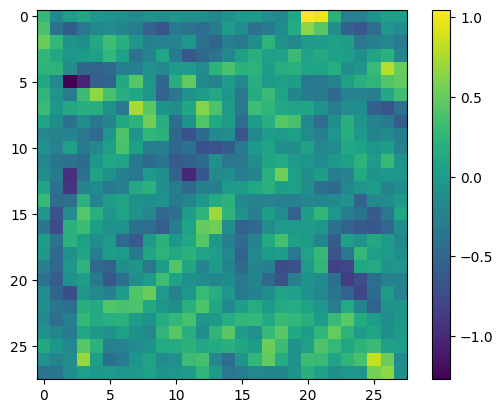

In [ ]:
import matplotlib.pyplot as plt
idx = 1
plt.imshow(output_feature_map['cnn_output'][0, idx].detach().cpu().numpy())
# Add a color bar
plt.colorbar()

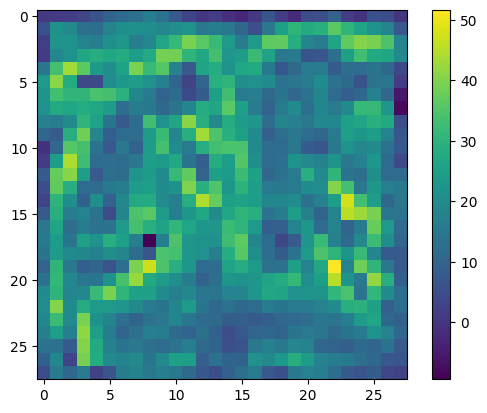

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(output_feature_map['cnn_output'][0].sum(0).detach().cpu().numpy())
# Add a color bar
plt.colorbar()

In [ ]:
 resnet18(weights=ResNet18_Weights.DEFAULT)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
A = torch.randn(1, 196, 768)
A = A.to(device)
torch.linalg.pinv(A)

TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

In [ ]:
A.device

device(type='mps', index=0)

In [ ]:
import torch

# # Example input
N, C, H, W = 1, 3, 224, 224  # Batch size N=2, Channels C=3, Height H and Width W both 224
# image = torch.randn(N, C, H, W)  # Random image tensor
image = inputs['pixel_values'].to('cpu')
mask = torch.randint(0, 2, (N, 196)).float()  # Random mask tensor with values 0 or 1


# Reshape and mask
patch_size = 16
patches = image.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)  # Create patches
patches = patches.contiguous().view(N, C, 196, patch_size*patch_size)  # Reshape to treat each patch separately
patches = patches.permute(0, 2, 1, 3).contiguous().view(N, 196, -1)  # Rearrange and flatten patches

# Expand the mask for element-wise multiplication
expanded_mask = mask.unsqueeze(-1).expand(-1, -1, patch_size*patch_size*C)

# Apply the mask
masked_patches = patches * expanded_mask

# To demonstrate the process, let's just reshape back to check the masked image shape (optional)
masked_image = masked_patches.view(N, 196, C, patch_size, patch_size).permute(0, 2, 1, 3, 4)
masked_image = masked_image.contiguous().view(N, C, H, W)  # Note: This simplification assumes patches are non-overlapping and cover the whole image

print(masked_image.shape)  # Should print torch.Size([N, 3, 224, 224])


torch.Size([1, 3, 224, 224])


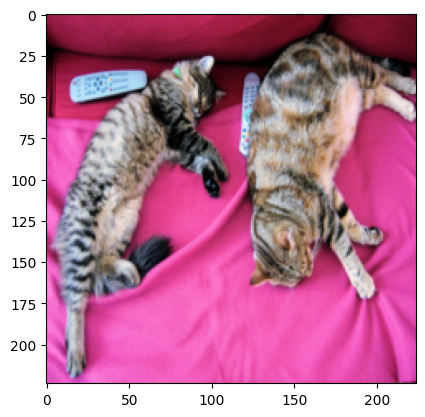

In [ ]:
image = inputs['pixel_values']
image = image * 0.5 + 0.5
import matplotlib.pyplot as plt
plt.imshow(image[0].detach().cpu().numpy().transpose(1, 2, 0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


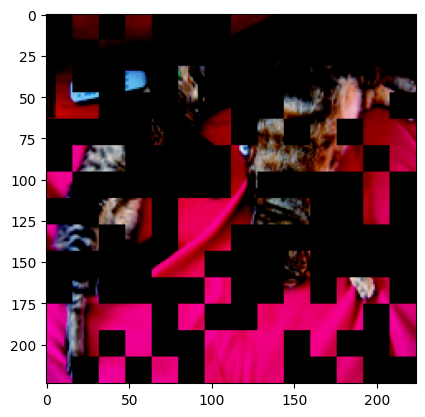

In [ ]:
def convert_mask_patch(pixel_values, mask, h_patch, w_patch):
    reshaped_mask = mask.reshape(-1, h_patch, w_patch).unsqueeze(1) # [N, 1, h_patch ,w_patch]
    image_size = pixel_values.shape[-2:]
    reshaped_mask = torch.nn.functional.interpolate(reshaped_mask, size=image_size, mode='nearest')
    return pixel_values * reshaped_mask

mask = torch.randint(0, 2, (N, 196)).float()
import matplotlib.pyplot as plt
masked_image = convert_mask_patch(image, mask, 14, 14)
plt.imshow(masked_image[0].detach().cpu().numpy().transpose(1, 2, 0))